In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE

from tf_lab.fundamentals.utils import set_visible_GPUs

from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.vae import VariationalAutoencoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.various_encoders_decoders as enc_dec
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]
experiment_name = 'emd_full_shapes_' + class_syn_id + '_vae_z30'

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/', class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/variational')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/variational/emd_full_shapes_03001627_vae_z30'

In [4]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=15)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [18]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds, 
                                                                    full_model_names],
                                                                    train_perc=0.95,
                                                                    validate_perc=0.0,
                                                                    test_perc=0.05,                                                                   
                                                                    seed=seed)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [6]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

set_visible_GPUs([3])

conf = Conf(n_input = [1024, 3],
            training_epochs = 1000,
            batch_size = 50,
            loss = 'chamfer',
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 5,
            learning_rate = 0.0001,
            saver_max_to_keep = 200,
            gauss_augment = {'mu': 0, 'sigma': 0.05},
            encoder = enc_dec.encoder_1dcovnv_5_points,
            decoder = enc_dec.decoder_only_with_fc,
            spatial_trans = True,
            denoising = False,
            n_z = 30,
            latent_vs_recon = 1.0,
            z_rotate = True
           )

reset_graph()
vae = VariationalAutoencoder(experiment_name, conf)
vae.train(train_data, conf)

('Epoch:', '0001', 'training time (minutes)=', '2.1159', 'loss=', '9623.853652954')
('Epoch:', '0002', 'training time (minutes)=', '0.1500', 'loss=', '7324.407371521')
('Epoch:', '0003', 'training time (minutes)=', '0.1600', 'loss=', '7145.476215363')
('Epoch:', '0004', 'training time (minutes)=', '0.1507', 'loss=', '7059.521167755')
('Epoch:', '0005', 'training time (minutes)=', '0.1519', 'loss=', '6987.186027527')
('Epoch:', '0006', 'training time (minutes)=', '0.1556', 'loss=', '6810.432170868')
('Epoch:', '0007', 'training time (minutes)=', '0.1564', 'loss=', '6773.001266479')
('Epoch:', '0008', 'training time (minutes)=', '0.1513', 'loss=', '6667.754852295')
('Epoch:', '0009', 'training time (minutes)=', '0.1497', 'loss=', '6586.720161438')
('Epoch:', '0010', 'training time (minutes)=', '0.1568', 'loss=', '6435.148963928')
('Epoch:', '0011', 'training time (minutes)=', '0.1498', 'loss=', '6425.604633331')
('Epoch:', '0012', 'training time (minutes)=', '0.1692', 'loss=', '6361.6820

[(1, 9623.8536529541016, 126.95138907432556),
 (2, 7324.4073715209961, 8.997228145599365),
 (3, 7145.4762153625488, 9.60125207901001),
 (4, 7059.521167755127, 9.039139986038208),
 (5, 6987.1860275268555, 9.112371921539307),
 (6, 6810.4321708679199, 9.338202953338623),
 (7, 6773.0012664794922, 9.385823011398315),
 (8, 6667.7548522949219, 9.079391956329346),
 (9, 6586.7201614379883, 8.981969118118286),
 (10, 6435.1489639282227, 9.405000925064087),
 (11, 6425.6046333312988, 8.988901853561401),
 (12, 6361.6820449829102, 10.1530921459198),
 (13, 6298.5979461669922, 8.980159044265747),
 (14, 6253.905704498291, 9.038748979568481),
 (15, 6106.8241882324219, 8.9933180809021),
 (16, 6115.0332412719727, 9.189234972000122),
 (17, 5963.694637298584, 8.991744995117188),
 (18, 5708.4473724365234, 9.161195039749146),
 (19, 5480.3502101898193, 9.027827024459839),
 (20, 5232.9968757629395, 8.987524032592773),
 (21, 5194.2162265777588, 8.81137204170227),
 (22, 5000.6871433258057, 9.822590827941895),
 (23

Model restored in epoch 5.
[ 522.83835793  512.06746928]
Model restored in epoch 105.
[ 224.86554682  225.68912252]
Model restored in epoch 205.
[ 205.8360678   205.79854075]
Model restored in epoch 305.
[ 198.39409292  193.80848694]
Model restored in epoch 405.
[ 189.91228521  189.35589345]
Model restored in epoch 505.
[ 191.48225069  189.91249084]
Model restored in epoch 605.
[ 196.06334746  197.22098541]
Model restored in epoch 705.
[ 187.04267132  187.79465739]
Model restored in epoch 805.
[ 185.22637999  184.14718119]
Model restored in epoch 905.
[ 184.74417615  182.73253123]


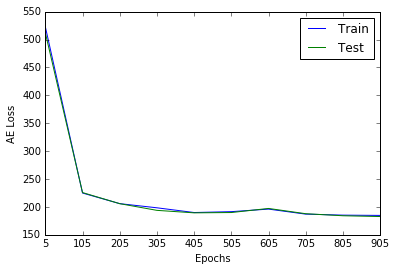

In [7]:
# saved_epochs = read_saved_epochs(conf.train_dir)
# epochs = saved_epochs[::len(saved_epochs)/10]
# stats = eval_model(vae, conf, [train_data, test_data], epochs=epochs, verbose=True)
# top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/variational/', experiment_name)
# plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [8]:
last_epoch = saved_epochs[-1]
vae.restore_model(conf.train_dir, last_epoch)

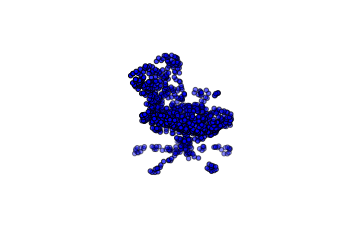

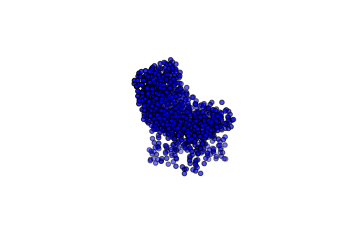

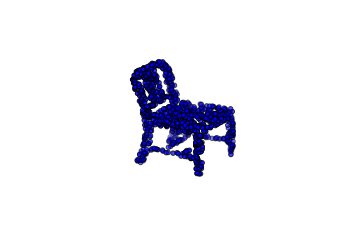

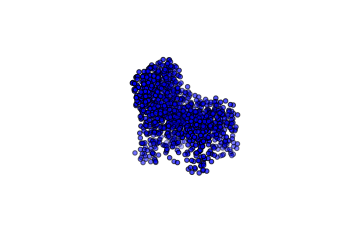

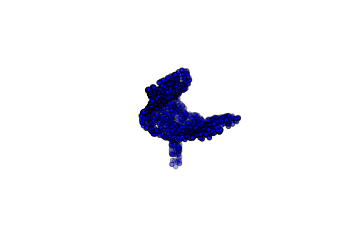

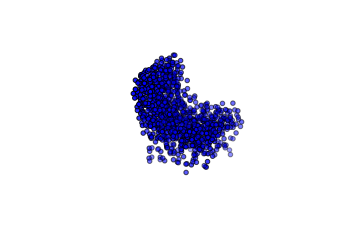

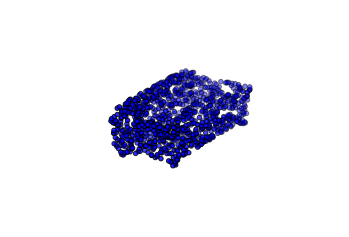

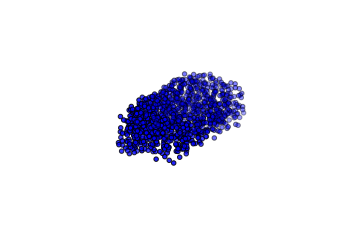

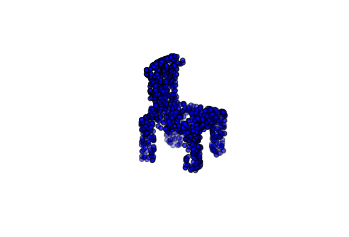

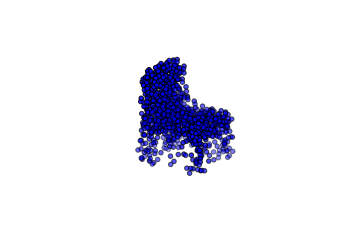

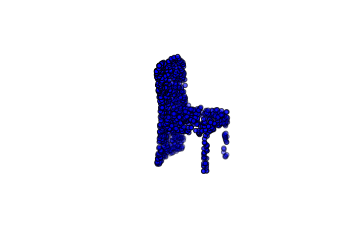

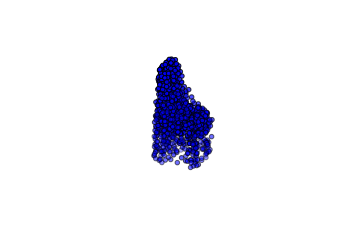

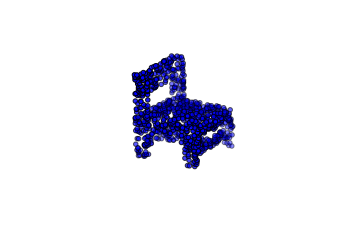

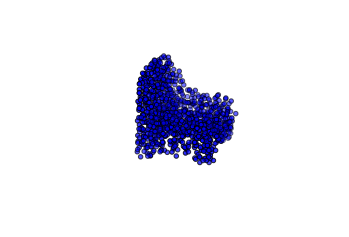

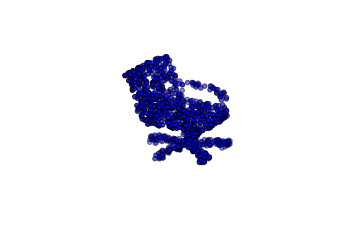

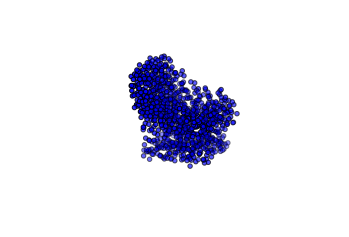

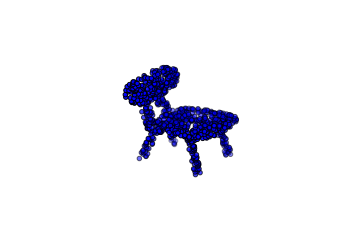

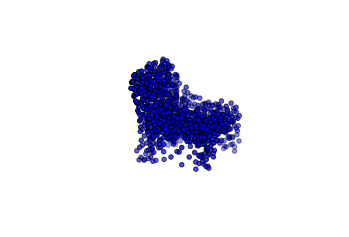

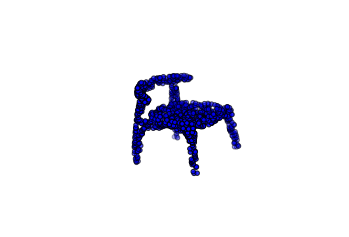

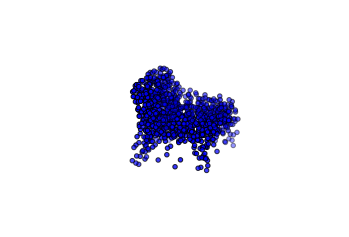

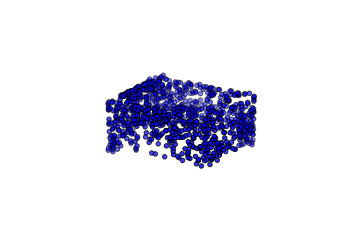

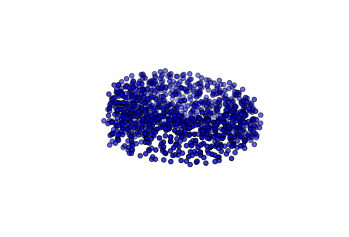

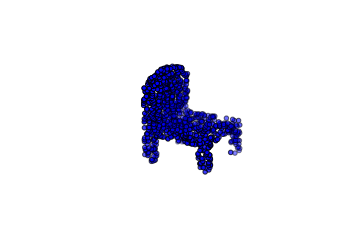

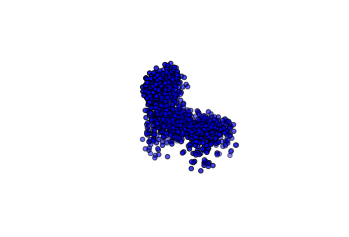

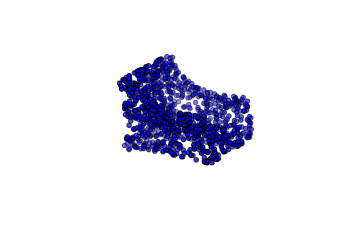

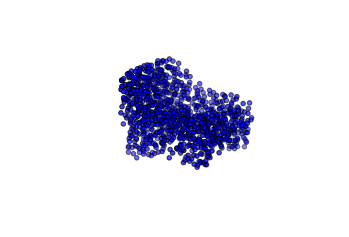

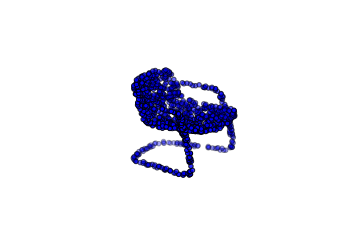

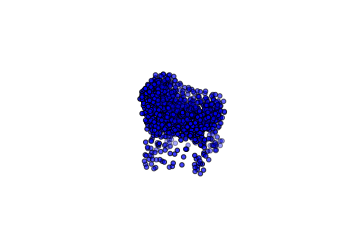

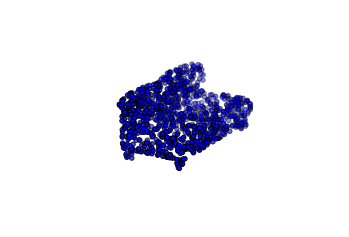

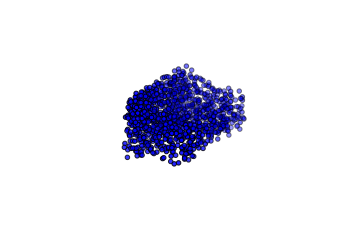

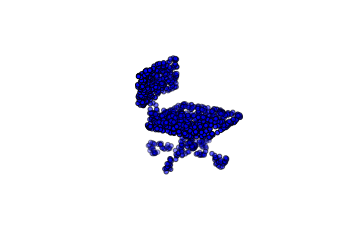

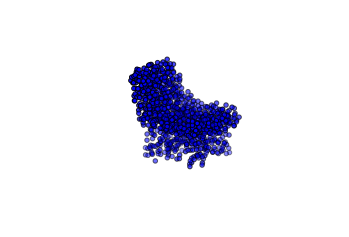

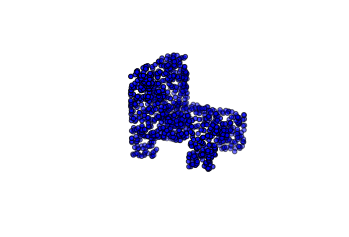

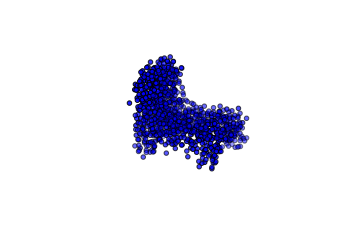

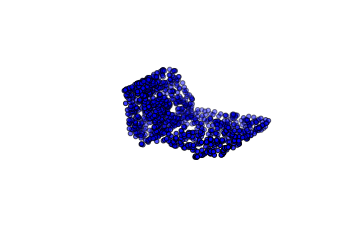

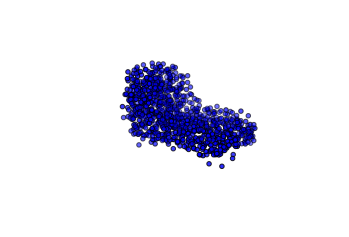

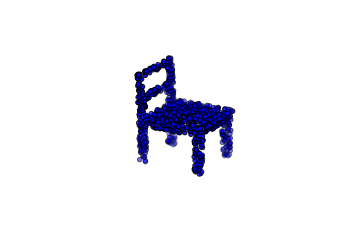

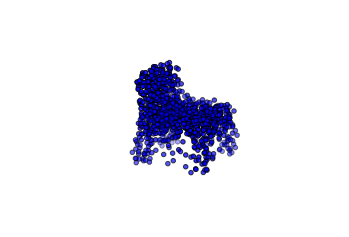

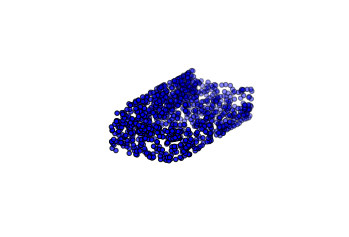

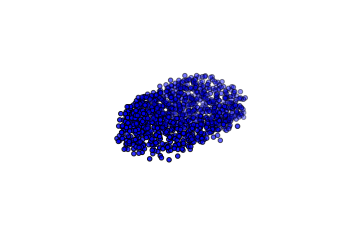

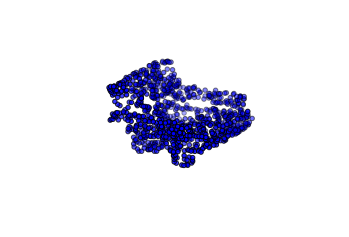

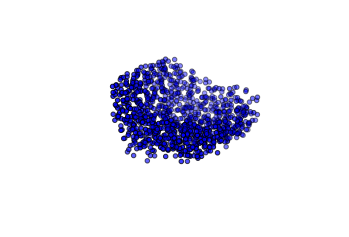

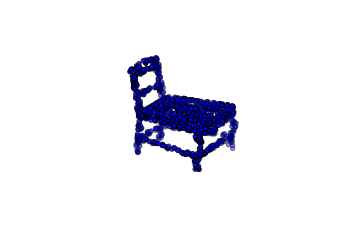

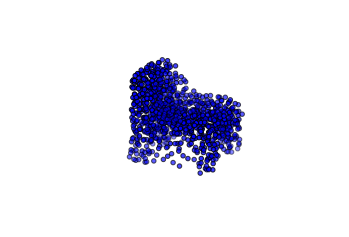

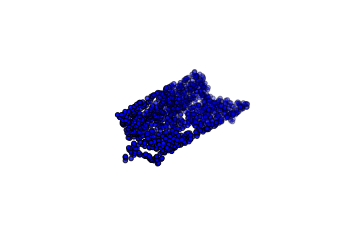

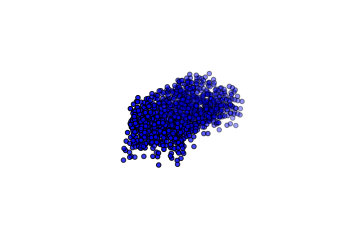

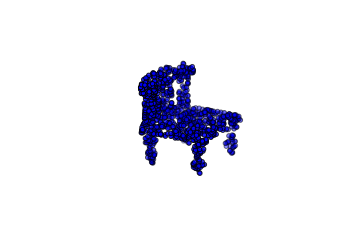

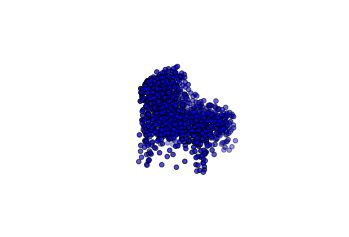

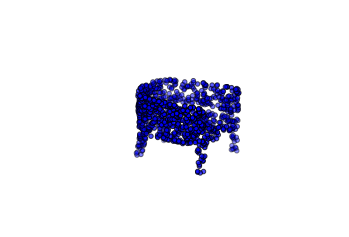

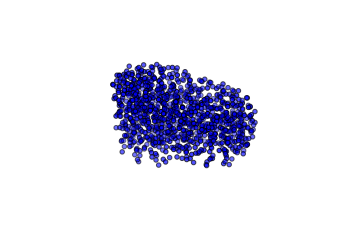

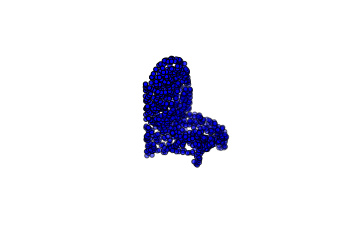

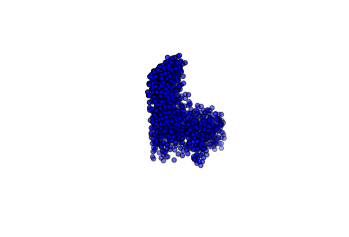

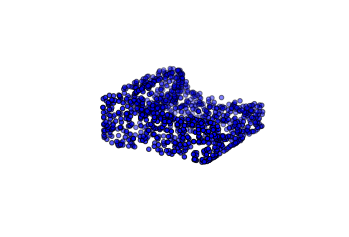

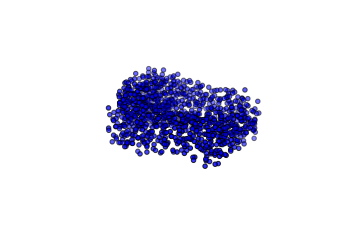

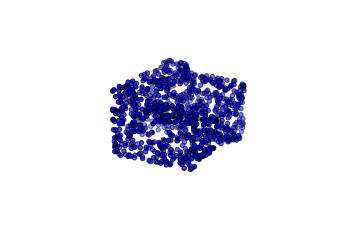

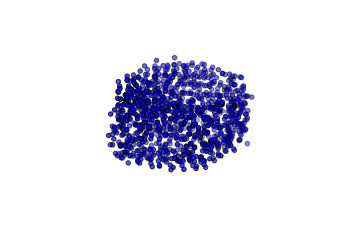

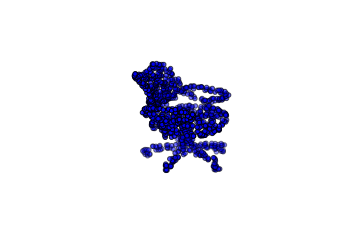

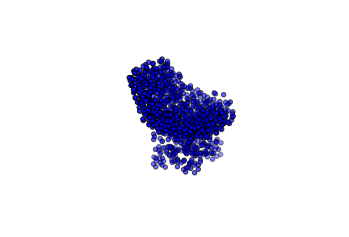

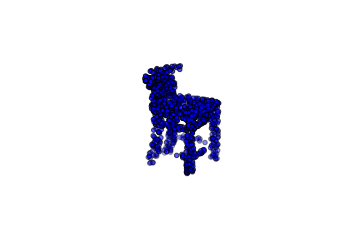

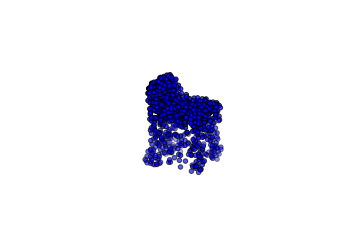

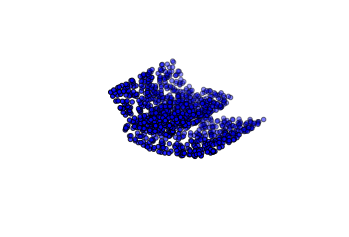

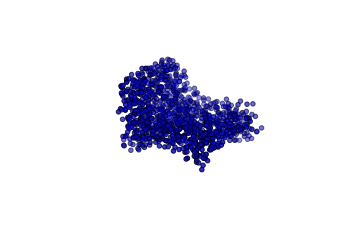

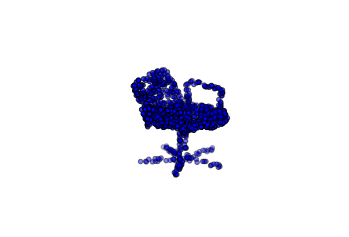

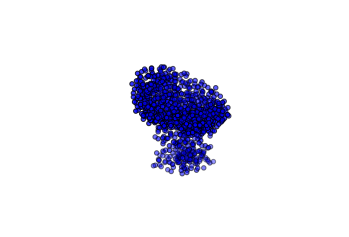

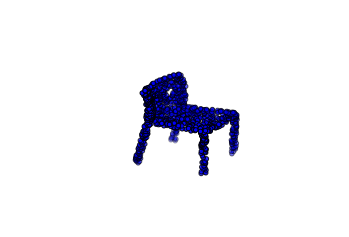

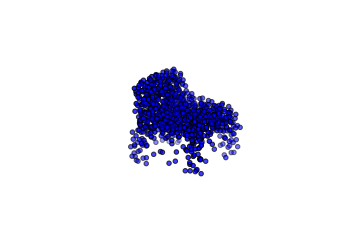

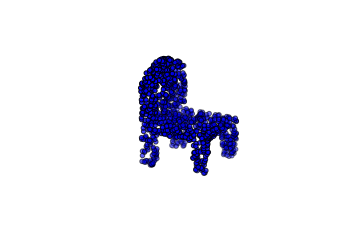

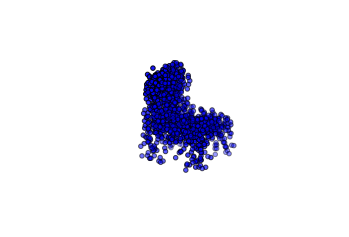

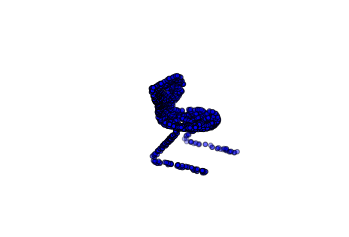

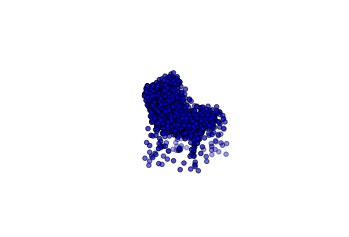

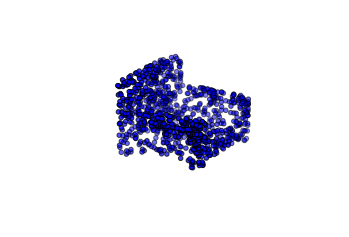

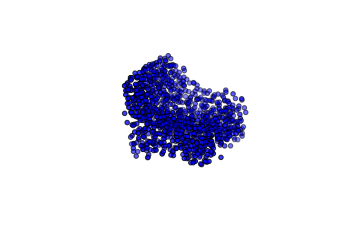

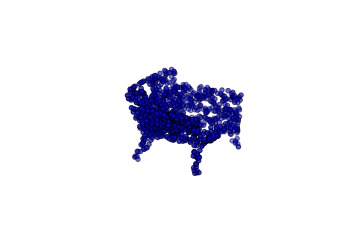

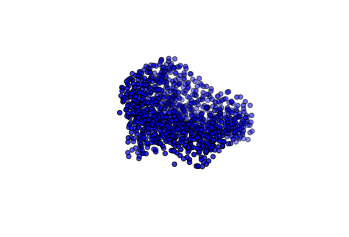

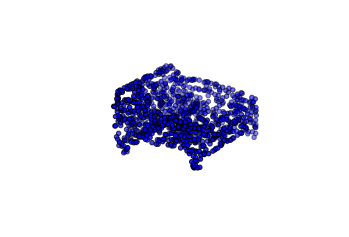

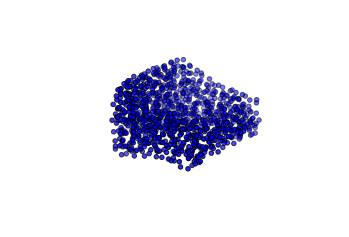

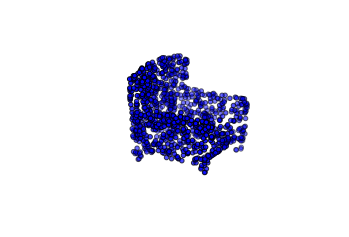

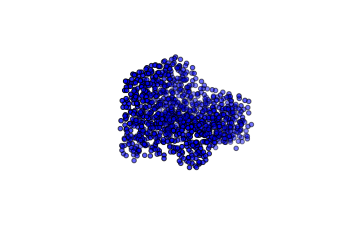

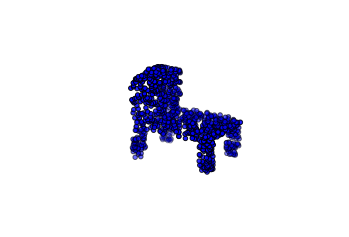

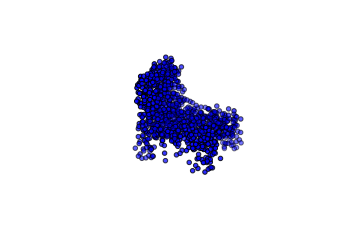

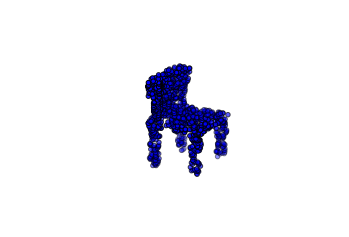

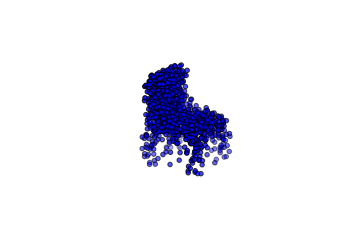

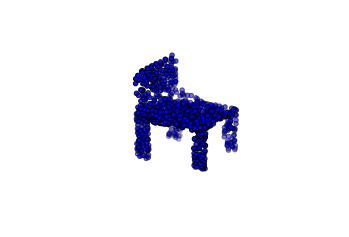

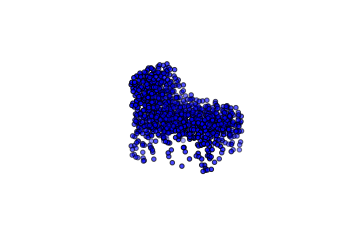

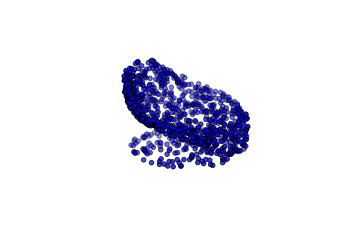

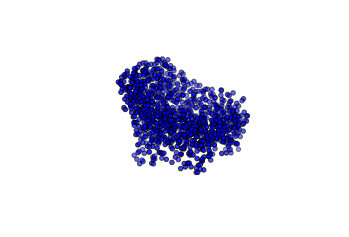

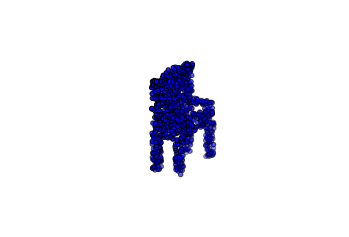

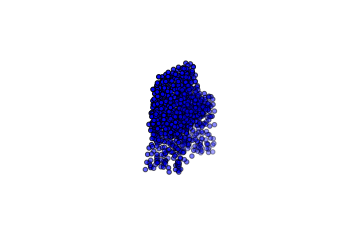

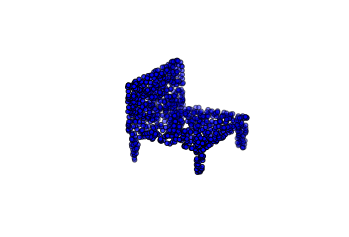

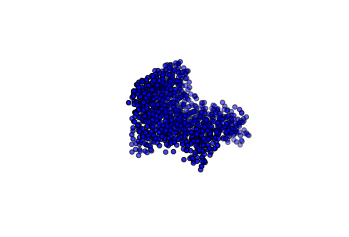

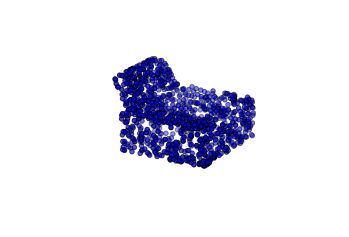

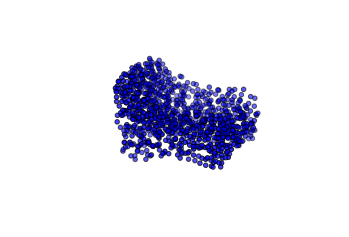

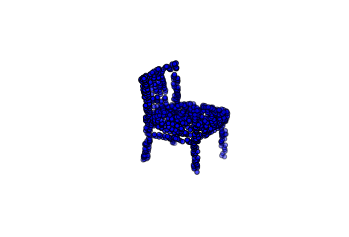

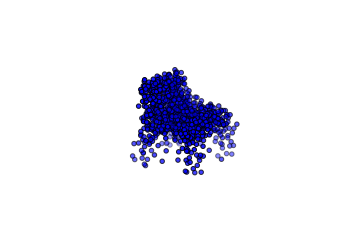

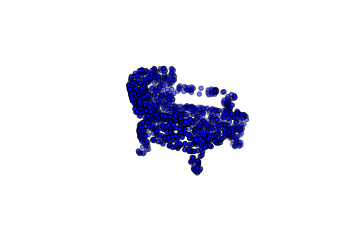

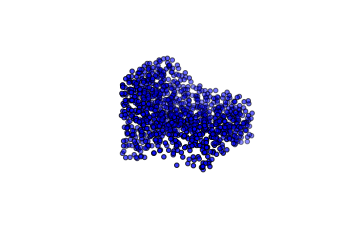

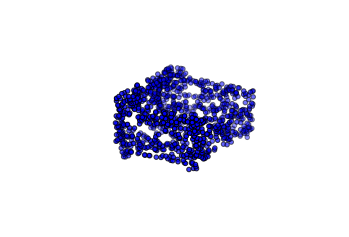

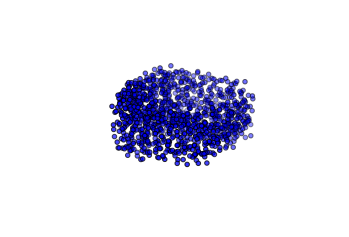

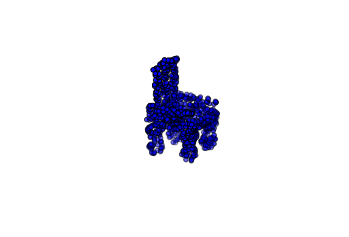

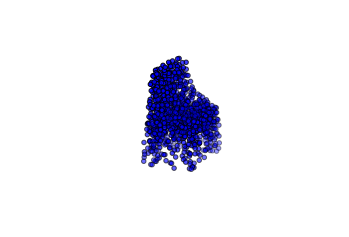

In [16]:
batch_size = conf.batch_size
feed = test_data.next_batch(batch_size)[0].reshape([batch_size] + conf.n_input)
res, loss = vae.reconstruct(feed)


loc = 1
for f,r in zip(feed, res):
    pc = Point_Cloud(points=f).center_in_unit_sphere()
#     ax = fig.add_subplot(10, 5, loc, projection='3d')    
    pc.plot(in_u_sphere=True, show=False);
    plt.axis('off')
    pc = Point_Cloud(points=r).center_in_unit_sphere()
    pc.plot(in_u_sphere=True, show=False);
    plt.axis('off')


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


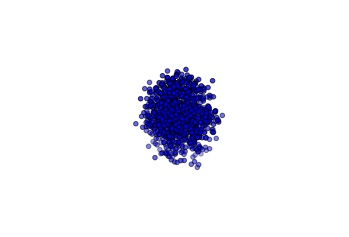

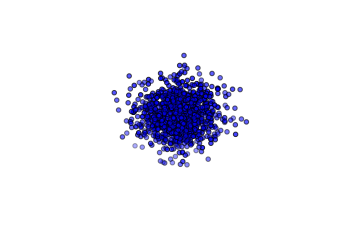

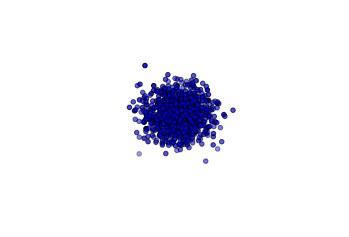

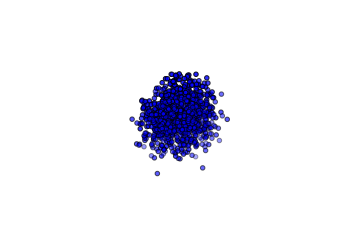

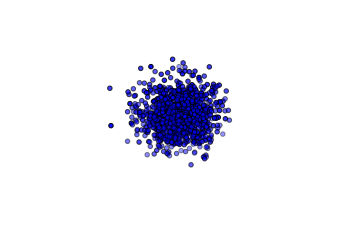

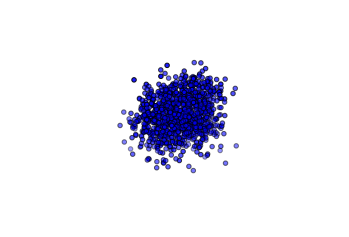

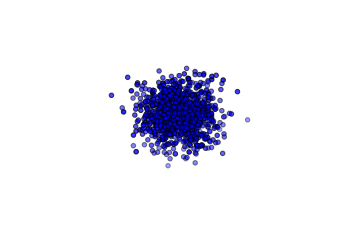

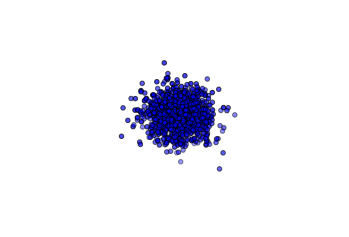

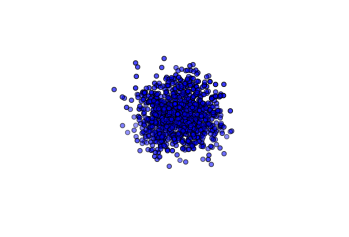

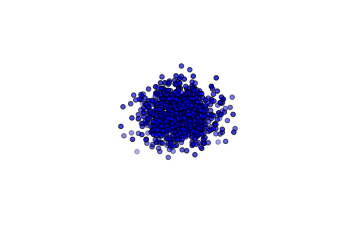

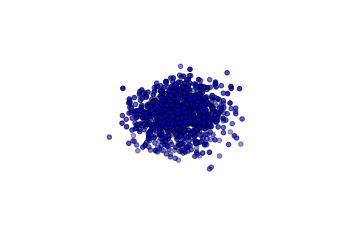

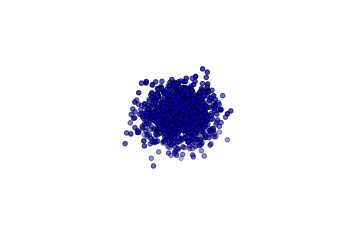

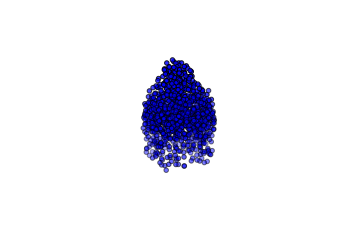

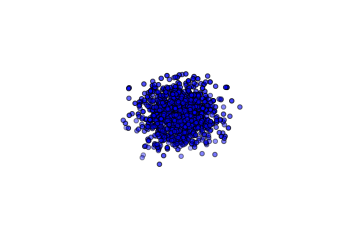

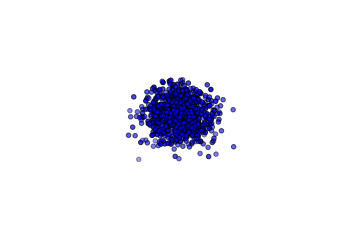

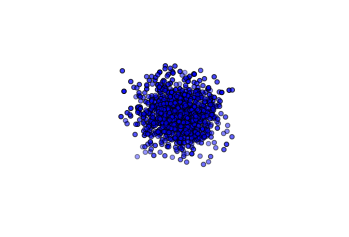

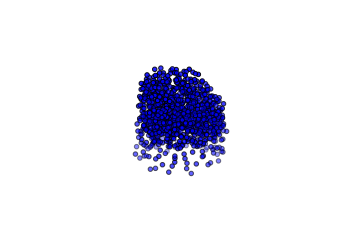

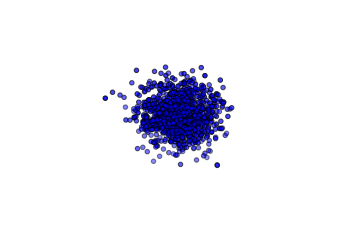

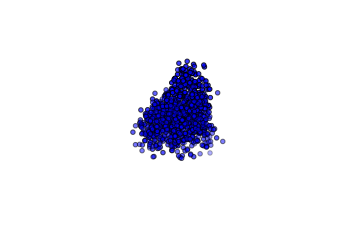

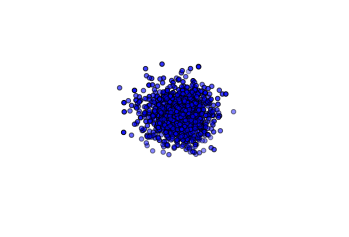

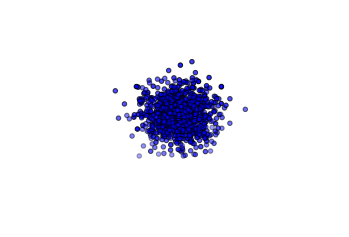

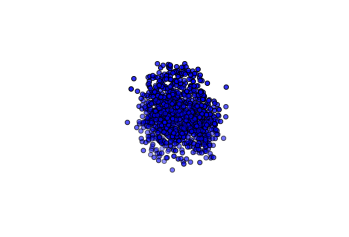

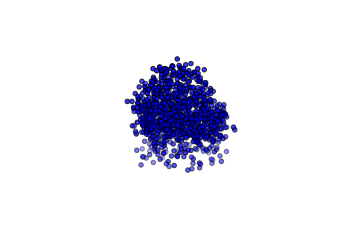

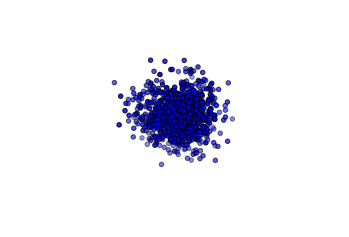

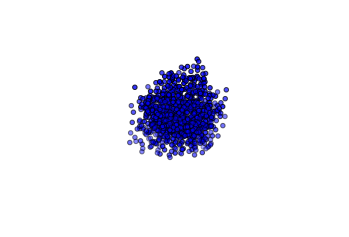

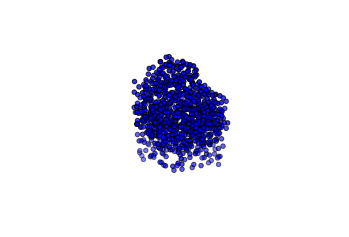

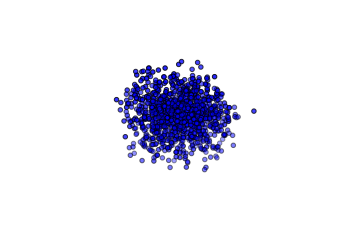

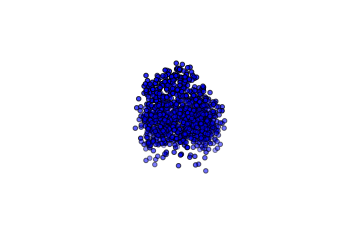

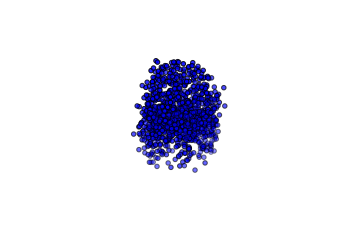

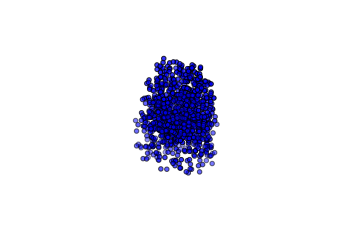

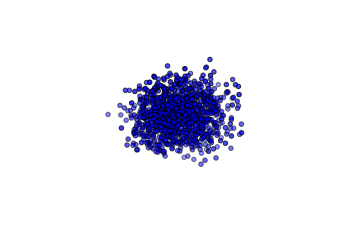

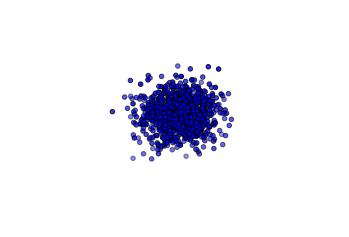

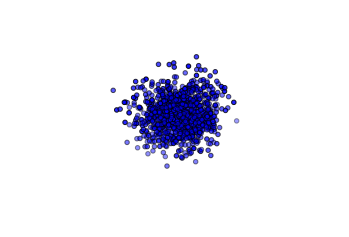

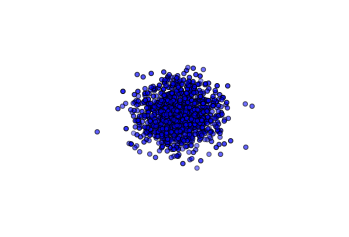

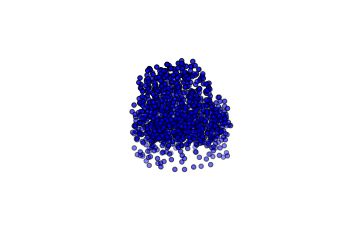

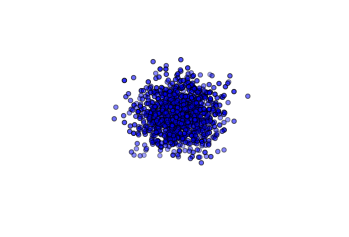

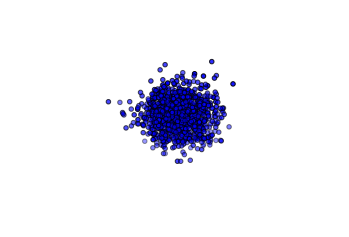

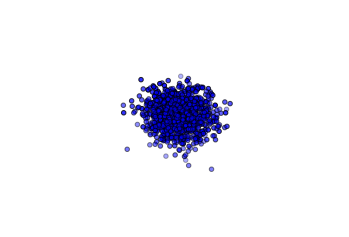

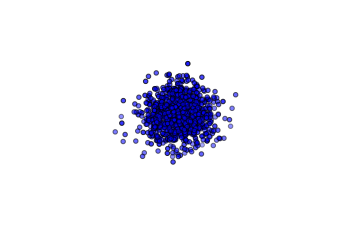

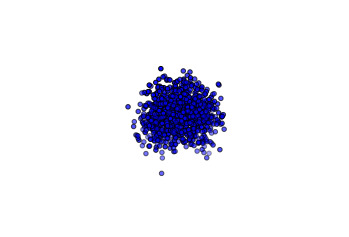

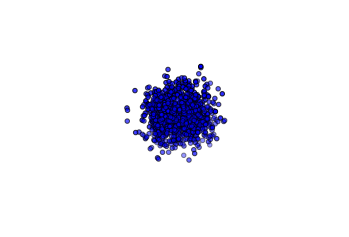

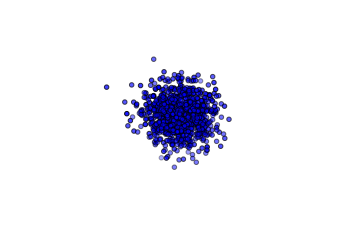

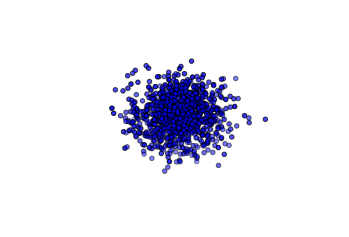

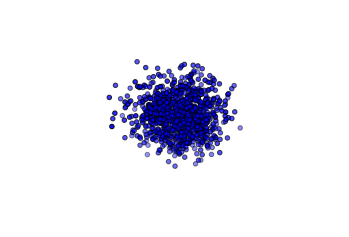

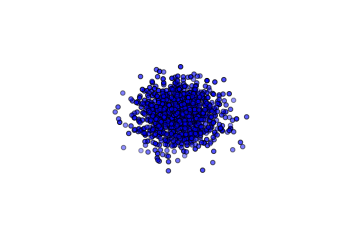

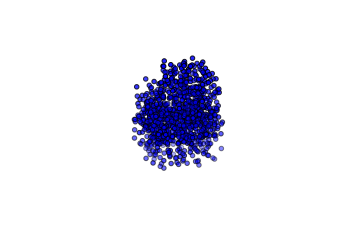

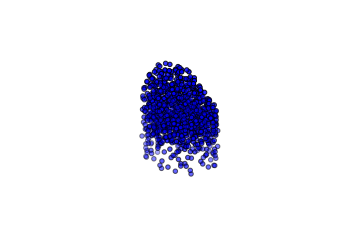

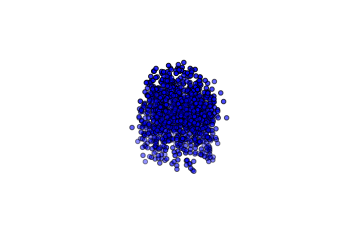

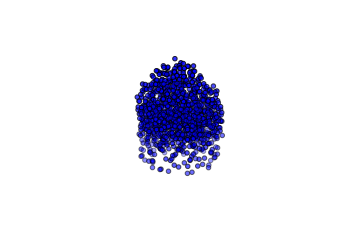

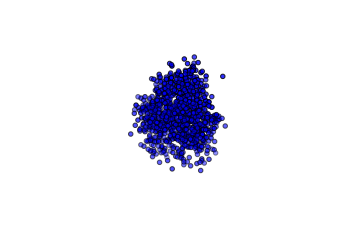

In [14]:
synthetic_data = vae.generate()
loc = 1
for p in synthetic_data:
    pc = Point_Cloud(points=p).center_in_unit_sphere()
#     ax = fig.add_subplot(10, 5, loc, projection='3d')    
    pc.plot(in_u_sphere=True, show=False);
    plt.axis('off')